In [ ]:
# Instalacion auto-TS
!pip -q install autots==0.6.14 pandas==2.2.2 numpy==2.0.2 scikit-learn==1.5.2 matplotlib==3.9.2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 843.3/843.3 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 132.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 112.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
umap-learn 0.5.9.post2 requires scikit-learn>=1.6, but you have scikit-learn 1.5.2 which is incompatible.


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
from autots import AutoTS
from sklearn.metrics import mean_absolute_error
import json

Mounted at /content/drive
CSV file loaded successfully!


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Leer csv
try:
    df = pd.read_csv('/content/drive/MyDrive/Datos_EESS/merged_df_clean.csv')
    print("CSV file loaded successfully!")
    display(df.head())
except FileNotFoundError:
    print("Error: Make sure the file path is correct.")
except Exception as e:
    print(f"An error occurred: {e}")

### AUTOML

In [ ]:
df_raw =pd.read_csv('/content/drive/MyDrive/Datos_EESS/merged_df_clean.csv')

In [ ]:
# Parametros generales del modelo
DATE_COL   = "fecha"
SERIES     = ["volumen_DSP", "volumen_NFP", "volumen_NFC"]
FREQ       = "D"
VAL_DAYS   = 90
TEST_DAYS  = 90
H          = 7  # horizonte a predecir

In [ ]:
# Normalizo fecha -> 'ds'
if DATE_COL in df_raw.columns and DATE_COL != "ds":
    df_raw = df_raw.rename(columns={DATE_COL: "ds"})
elif "ds" not in df_raw.columns:
    raise ValueError("No encuentro columna de fecha. Esperaba 'fecha' o 'ds'.")

# Orrdeno
df_raw["ds"] = pd.to_datetime(df_raw["ds"])
df_raw = df_raw.sort_values("ds").reset_index(drop=True)

# Verifico columnas presentes
missing = [c for c in SERIES if c not in df_raw.columns]
if missing:
    raise ValueError(f"Faltan series en el CSV: {missing}")

# Reindex a calendario continuo diario (sin inventar target)
df_idx = df_raw.set_index("ds")
full_range = pd.date_range(df_idx.index.min(), df_idx.index.max(), freq=FREQ)
df_idx = df_idx.reindex(full_range)

# Agrego ds como fecha
df_wide = df_idx[SERIES].copy()
df_wide = df_wide.reset_index().rename(columns={"index": "ds"})

# Quitamos NaN (afecta a los modelos)
df_wide = df_wide.dropna(subset=SERIES, how="all").reset_index(drop=True)

In [ ]:
# Split temporal: train -val - test
# verifico tamaño
n = len(df_wide)
if (VAL_DAYS + TEST_DAYS + H) >= n:
    raise ValueError("Muy pocos datos para los tamaños de VAL/TEST/H. Ajustá parámetros.")

train_end = n - (VAL_DAYS + TEST_DAYS)
val_end   = n - TEST_DAYS

train_df = df_wide.iloc[:train_end].copy()
val_df   = df_wide.iloc[train_end:val_end].copy()
test_df  = df_wide.iloc[val_end:].copy()

print(f"Split -> train={len(train_df)}, val={len(val_df)}, test={len(test_df)}")
print("Rangos:",
      f"train[{train_df['ds'].min().date()}..{train_df['ds'].max().date()}],",
      f"val[{val_df['ds'].min().date()}..{val_df['ds'].max().date()}],",
      f"test[{test_df['ds'].min().date()}..{test_df['ds'].max().date()}]")
# Tiene que tener como salida val= 90 test= 90

Split -> train=922, val=90, test=90
Rangos: train[2022-04-01..2024-10-08], val[2024-10-09..2025-01-06], test[2025-01-07..2025-04-06]


In [ ]:
#AutoTS
trainval_df = pd.concat([train_df, val_df], axis=0, ignore_index=True)

trainval_long = trainval_df.melt(
    id_vars=["ds"],
    value_vars=SERIES,
    var_name="series_id",
    value_name="value"
).rename(columns={"ds": "date"}).dropna(subset=["value"])

# Modelo AutoTS
model = AutoTS(
    forecast_length=H,
    frequency=FREQ,
    prediction_interval=0.9,
    ensemble="simple",             # 'simple' / 'horizontal' / 'all'
    model_list="fast",             # 'superfast' / 'fast' / 'default'
    transformer_list="superfast",
    max_generations=6,             # subí para más calidad/tiempo
    num_validations=2,
    validation_method="backwards",
    n_jobs="auto",
    verbose=1,
)

model = model.fit(
    trainval_long,
    date_col="date",
    value_col="value",
    id_col="series_id",
)

Using 4 cpus for n_jobs.
Data frequency is: D, used frequency is: D
Model Number: 1 with model AverageValueNaive in generation 0 of 6
Model Number: 2 with model AverageValueNaive in generation 0 of 6
Model Number: 3 with model AverageValueNaive in generation 0 of 6
Model Number: 4 with model DatepartRegression in generation 0 of 6
Model Number: 5 with model DatepartRegression in generation 0 of 6
Model Number: 6 with model DatepartRegression in generation 0 of 6


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 7 with model DatepartRegression in generation 0 of 6


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3578
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3531
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3443
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3400
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3379
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3327
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3308
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3276
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3220
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3209
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3156
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3157
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3160
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3136
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3149
Epoch 16/50
32/32 ━

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 29 with model DatepartRegression in generation 0 of 6
Model Number: 30 with model ETS in generation 0 of 6
Model Number: 31 with model VECM in generation 0 of 6
Model Number: 32 with model UnivariateMotif in generation 0 of 6
Model Number: 33 with model UnivariateMotif in generation 0 of 6
Model Number: 34 with model SectionalMotif in generation 0 of 6
Model Number: 35 with model SectionalMotif in generation 0 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


Model Number: 36 with model SeasonalNaive in generation 0 of 6
Model Number: 37 with model DatepartRegression in generation 0 of 6
Model Number: 38 with model NVAR in generation 0 of 6
Model Number: 39 with model Cassandra in generation 0 of 6
Model Number: 40 with model SeasonalityMotif in generation 0 of 6
Model Number: 41 with model Cassandra in generation 0 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `p

Model Number: 42 with model Cassandra in generation 0 of 6
Model Number: 43 with model Cassandra in generation 0 of 6
Model Number: 44 with model ConstantNaive in generation 0 of 6
Model Number: 45 with model LastValueNaive in generation 0 of 6
Model Number: 46 with model AverageValueNaive in generation 0 of 6
Model Number: 47 with model GLS in generation 0 of 6
Model Number: 48 with model SeasonalNaive in generation 0 of 6
Model Number: 49 with model GLM in generation 0 of 6
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 49 in generation 0: GLM
Model Number: 50 with model ETS in generation 0 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1650: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))


Model Number: 51 with model VAR in generation 0 of 6
Model Number: 52 with model VECM in generation 0 of 6
Model Number: 53 with model WindowRegression in generation 0 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 53 in generation 0: WindowRegression
Model Number: 54 with model DatepartRegression in generation 0 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 55 with model UnivariateMotif in generation 0 of 6
Model Number: 56 with model SectionalMotif in generation 0 of 6
Model Number: 57 with model NVAR in generation 0 of 6
Model Number: 58 with model MAR in generation 0 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 59 with model RRVAR in generation 0 of 6
Model Number: 60 with model KalmanStateSpace in generation 0 of 6
Template Eval Error: Exception("Transformer Detrend failed on fit from params ffill {'0': {'method': 'clip', 'std_threshold': 4, 'fillna': None}, '1': {'model': 'GLS', 'phi': 1, 'window': 10, 'transform_dict': None}, '2': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'AnomalyRemoval'}, 'transformation_params': {'0': {'method': 'zscore', 'transform_dict': {'transformations': {'0': 'DatepartRegression'}, 'transformation_params': {'0': {'datepart_method': 'simple_3', 'regression_model': {'model': 'ElasticNet', 'model_params': {}}}}}, 'method_params': {'distribution': 'uniform', 'alpha': 0.05}}}}}}") in model 60 in generation 0: KalmanStateSpace
Model Number: 61 with model MetricMotif in generation 0 of 6
Model Number: 62 with model Cassandra in generation 0 of 6


/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.06124e-25): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Model Number: 63 with model SeasonalityMotif in generation 0 of 6
Model Number: 64 with model FFT in generation 0 of 6
Model Number: 65 with model BallTreeMultivariateMotif in generation 0 of 6
Model Number: 66 with model GLM in generation 0 of 6
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 66 in generation 0: GLM
Model Number: 67 with model MetricMotif in generation 0 of 6
Model Number: 68 with model DatepartRegression in generation 0 of 6
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params ffill {'0': {'method': 'clip', 'std_threshold': 3, 'fillna': None}, '1': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'bkfilter'}, 'transformation_params': {'0': {}}}}, '2': {}, '3': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': 10}}") in model 68 in generation 0: DatepartRegressio

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 75 with model GLS in generation 0 of 6
Model Number: 76 with model WindowRegression in generation 0 of 6
Model Number: 77 with model FFT in generation 0 of 6
Model Number: 78 with model ConstantNaive in generation 0 of 6
Model Number: 79 with model MetricMotif in generation 0 of 6
Model Number: 80 with model MetricMotif in generation 0 of 6
Model Number: 81 with model KalmanStateSpace in generation 0 of 6
Model Number: 82 with model WindowRegression in generation 0 of 6
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params ffill_mean_biased {'0': {'rows': 1, 'lag': 2, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': 10}, '1': {'lag_1': 7, 'method': 5}, '2': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'ScipyFilter'}, 'transformation_params': {'0': {'method': 'savgol_filter', 'method_args': {'window_length': 31, 'polyorder': 3, 'deriv': 0, 'mode': 'i

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply
  wlsendog = (lin_pred + self.family.link.deriv(mu) * (self.endog-mu)
/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: Fu

Model Number: 94 with model ConstantNaive in generation 0 of 6
Model Number: 95 with model UnivariateMotif in generation 0 of 6
Model Number: 96 with model DatepartRegression in generation 0 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 96 in generation 0: DatepartRegression
Model Number: 97 with model GLM in generation 0 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 97 in generation 0: GLM
Model Number: 98 with model ConstantNaive in generation 0 of 6
Model Number: 99 with model UnivariateMotif in generation 0 of 6
Model Number: 100 with model UnivariateMotif in generation 0 of 6
Model Number: 101 with model SectionalMotif in generation 0 of 6
Model Number: 102 with model NVAR in generation 0 of 6
Model Number: 103 with model LastValueNaive in generation 0 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: overflow encountered in square
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:325: RuntimeWarning: divide by zero encountered in power
  return np.power(z, 1. / self.power)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:775: RuntimeWarning: invalid value encountered in divide
  resid_dev = -np.log(endog_mu) + (endog - mu) / mu
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:898: RuntimeWarning: invalid value encountered in divide
  return np.sum(resid / self.family.variance(mu)) / self.df_resid
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.12/dist-packages/statsm

Model Number: 104 with model VAR in generation 0 of 6
Model Number: 105 with model WindowRegression in generation 0 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 105 in generation 0: WindowRegression
Model Number: 106 with model BallTreeMultivariateMotif in generation 0 of 6
Model Number: 107 with model ConstantNaive in generation 0 of 6
Model Number: 108 with model SeasonalityMotif in generation 0 of 6
Model Number: 109 with model SeasonalityMotif in generation 0 of 6
Model Number: 110 with model ConstantNaive in generation 0 of 6
Model Number: 111 with model RRVAR in generation 0 of 6
Model Number: 112 with model ConstantNaive in generation 0 of 6
Model Number: 113 with model UnivariateMotif in generation 0 of 6
Model Number: 114 with model MAR in generation 0 of 6
Model Number: 115 with model MetricMotif in generation 0 of 6
Model Number: 116 with model VECM in generation 0 of 6
Model Number: 117 with model SectionalMotif in g

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/usr/local/lib/python3.12/dist-packages/

Model Number: 150 with model VECM in generation 0 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 150 in generation 0: VECM
Model Number: 151 with model MAR in generation 0 of 6
Model Number: 152 with model UnivariateMotif in generation 0 of 6
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params ffill {'0': {'method': 'clip', 'std_threshold': 4, 'fillna': None}, '1': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': None}, '2': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': None}, '3': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': None}}") in model 152 in generation 0: UnivariateMotif
Model Number: 153 with model SeasonalNaive in generation 0 of 6
New Generation: 1 of 6
Model Number: 154 with model UnivariateMotif in generation 1 of 6
Model Number: 155 with model GLS in generation 1 of 6
Model Number: 156 with 

/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_regression.py:509: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 161 with model ETS in generation 1 of 6
Model Number: 162 with model VECM in generation 1 of 6
Model Number: 163 with model GLS in generation 1 of 6
Model Number: 164 with model ConstantNaive in generation 1 of 6
Model Number: 165 with model MetricMotif in generation 1 of 6
Model Number: 166 with model GLS in generation 1 of 6
Model Number: 167 with model SectionalMotif in generation 1 of 6
Model Number: 168 with model SectionalMotif in generation 1 of 6
Model Number: 169 with model ETS in generation 1 of 6
Model Number: 170 with model SeasonalNaive in generation 1 of 6
Model Number: 171 with model LastValueNaive in generation 1 of 6
Model Number: 172 with model SeasonalNaive in generation 1 of 6
Model Number: 173 with model DatepartRegression in generation 1 of 6
Model Number: 174 with model NVAR in generation 1 of 6
Model Number: 175 with model FFT in generation 1 of 6
Template Eval Error: Exception("Transformer Detrend failed on fit from params nearest {'0': {'model': 

/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 180 with model WindowRegression in generation 1 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 180 in generation 1: WindowRegression
Model Number: 181 with model MAR in generation 1 of 6
Model Number: 182 with model RRVAR in generation 1 of 6
Model Number: 183 with model VAR in generation 1 of 6
Model Number: 184 with model SeasonalityMotif in generation 1 of 6
Model Number: 185 with model SectionalMotif in generation 1 of 6
Model Number: 186 with model SectionalMotif in generation 1 of 6
Model Number: 187 with model SeasonalNaive in generation 1 of 6
Model Number: 188 with model SeasonalityMotif in generation 1 of 6
Model Number: 189 with model UnivariateMotif in generation 1 of 6
Model Number: 190 with model Cassandra in generation 1 of 6
Model Number: 191 with model AverageValueNaive in generation 1 of 6
Model Number: 192 with model SeasonalNaive in generation 1 of 6
Model Number: 193 with model AverageValueNaive 

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. C

Model Number: 196 with model AverageValueNaive in generation 1 of 6
Model Number: 197 with model LastValueNaive in generation 1 of 6
Model Number: 198 with model SectionalMotif in generation 1 of 6
Model Number: 199 with model SeasonalityMotif in generation 1 of 6
Model Number: 200 with model MetricMotif in generation 1 of 6
Model Number: 201 with model DatepartRegression in generation 1 of 6
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1089
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0450
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0435
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0413
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0409
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0397
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0387
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0388
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0381
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0379
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0371
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0363
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0369
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0363
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0363
Epoch 16/50
32/32 ━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


Model Number: 215 with model VECM in generation 1 of 6
Model Number: 216 with model DatepartRegression in generation 1 of 6
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.1017
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0453
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0429
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0421
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0417
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0411
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0396
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0393
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0392
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0373
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0368
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0359
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0357
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0359
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0356
Epoch 16/50
32/32 ━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


Model Number: 219 with model GLS in generation 1 of 6
Model Number: 220 with model FFT in generation 1 of 6
Model Number: 221 with model SeasonalityMotif in generation 1 of 6
Model Number: 222 with model AverageValueNaive in generation 1 of 6
Model Number: 223 with model Cassandra in generation 1 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 224 with model RRVAR in generation 1 of 6
Model Number: 225 with model UnivariateMotif in generation 1 of 6
Model Number: 226 with model DatepartRegression in generation 1 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 226 in generation 1: DatepartRegression
Model Number: 227 with model SeasonalNaive in generation 1 of 6
Model Number: 228 with model VAR in generation 1 of 6
Model Number: 229 with model SectionalMotif in generation 1 of 6
Model Number: 230 with model ETS in generation 1 of 6
Model Number: 231 with model VAR in generation 1 of 6
Model Number: 232 with model MAR in generation 1 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 233 with model VECM in generation 1 of 6
Model Number: 234 with model Cassandra in generation 1 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 235 with model Cassandra in generation 1 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 236 with model SeasonalNaive in generation 1 of 6
Model Number: 237 with model SeasonalNaive in generation 1 of 6
Model Number: 238 with model SeasonalNaive in generation 1 of 6
Model Number: 239 with model SectionalMotif in generation 1 of 6
Model Number: 240 with model SeasonalityMotif in generation 1 of 6
Model Number: 241 with model DatepartRegression in generation 1 of 6
Model Number: 242 with model RRVAR in generation 1 of 6
Model Number: 243 with model LastValueNaive in generation 1 of 6
Model Number: 244 with model NVAR in generation 1 of 6
Model Number: 245 with model MAR in generation 1 of 6
Model Number: 246 with model FFT in generation 1 of 6
Model Number: 247 with model RRVAR in generation 1 of 6
Model Number: 248 with model GLM in generation 1 of 6
Model Number: 249 with model VAR in generation 1 of 6
Model Number: 250 with model GLM in generation 1 of 6
Model Number: 251 with model LastValueNaive in generation 1 of 6
Model Number: 252 with model VAR in gene

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 256 with model NVAR in generation 1 of 6
Model Number: 257 with model ETS in generation 1 of 6
Model Number: 258 with model WindowRegression in generation 1 of 6
Template Eval Error: ValueError("Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.") in model 258 in generation 1: WindowRegression
Model Number: 259 with model MetricMotif in generation 1 of 6
Model Number: 260 with model VAR in generation 1 of 6
Model Number: 261 with model ConstantNaive in generation 1 of 6
Model Number: 262 with model FFT in generation 1 of 6
Model Number: 263 with model ConstantNaive in generation 1 of 6
New Generation: 2 of 6
Model Number: 264 with model FFT in generation 2 of 6
Model Number: 265 with model UnivariateMotif in generation 2 of 6
Model Number: 266 with model FFT in generation 2 of 6
Model Number: 267 with model MAR in generation 2 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 268 with model FFT in generation 2 of 6
Model Number: 269 with model SeasonalNaive in generation 2 of 6
Model Number: 270 with model UnivariateMotif in generation 2 of 6
Model Number: 271 with model VECM in generation 2 of 6
Model Number: 272 with model SeasonalityMotif in generation 2 of 6
Model Number: 273 with model LastValueNaive in generation 2 of 6
Model Number: 274 with model SectionalMotif in generation 2 of 6
Model Number: 275 with model GLM in generation 2 of 6
Model Number: 276 with model GLM in generation 2 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 277 with model LastValueNaive in generation 2 of 6
Model Number: 278 with model AverageValueNaive in generation 2 of 6
Model Number: 279 with model SeasonalNaive in generation 2 of 6
Model Number: 280 with model LastValueNaive in generation 2 of 6
Model Number: 281 with model Cassandra in generation 2 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.06124e-25): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Model Number: 282 with model Cassandra in generation 2 of 6
Template Eval Error: ValueError('The covariance matrix of the support data is equal to 0, try to increase support_fraction') in model 282 in generation 2: Cassandra
Model Number: 283 with model VAR in generation 2 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1402: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/usr/local/lib/pyt

Model Number: 284 with model GLM in generation 2 of 6
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 284 in generation 2: GLM
Model Number: 285 with model MetricMotif in generation 2 of 6
Model Number: 286 with model SectionalMotif in generation 2 of 6
Model Number: 287 with model VECM in generation 2 of 6
Model Number: 288 with model SeasonalNaive in generation 2 of 6
Model Number: 289 with model DatepartRegression in generation 2 of 6
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1890.4868
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1890.2263
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1889.7291
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1889.2986
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1889.0057
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1888.7546
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1888.5376
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1888.3293
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1888.1290
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1887.9398
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1887.7526
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1887.5756
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1887.3998
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1887.2302
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - l

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


Model Number: 292 with model RRVAR in generation 2 of 6
Model Number: 293 with model GLM in generation 2 of 6
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 293 in generation 2: GLM
Model Number: 294 with model RRVAR in generation 2 of 6
Model Number: 295 with model RRVAR in generation 2 of 6
Model Number: 296 with model VAR in generation 2 of 6
Model Number: 297 with model MetricMotif in generation 2 of 6
Model Number: 298 with model SeasonalNaive in generation 2 of 6
Model Number: 299 with model BallTreeMultivariateMotif in generation 2 of 6
Model Number: 300 with model MAR in generation 2 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 301 with model SeasonalNaive in generation 2 of 6
Model Number: 302 with model FFT in generation 2 of 6
Model Number: 303 with model SectionalMotif in generation 2 of 6
Model Number: 304 with model RRVAR in generation 2 of 6
Model Number: 305 with model VAR in generation 2 of 6
Model Number: 306 with model RRVAR in generation 2 of 6
Model Number: 307 with model VAR in generation 2 of 6
Model Number: 308 with model MAR in generation 2 of 6
Model Number: 309 with model SectionalMotif in generation 2 of 6
Model Number: 310 with model RRVAR in generation 2 of 6
Model Number: 311 with model SeasonalNaive in generation 2 of 6
Model Number: 312 with model NVAR in generation 2 of 6
Model Number: 313 with model SeasonalityMotif in generation 2 of 6
Model Number: 314 with model DatepartRegression in generation 2 of 6
Model Number: 315 with model AverageValueNaive in generation 2 of 6
Model Number: 316 with model MAR in generation 2 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 317 with model SectionalMotif in generation 2 of 6
Model Number: 318 with model UnivariateMotif in generation 2 of 6
Model Number: 319 with model ConstantNaive in generation 2 of 6
Model Number: 320 with model MetricMotif in generation 2 of 6
Model Number: 321 with model MetricMotif in generation 2 of 6
Model Number: 322 with model BallTreeMultivariateMotif in generation 2 of 6
Template Eval Error: ValueError('Shape of weights must be consistent with shape of a along specified axis.') in model 322 in generation 2: BallTreeMultivariateMotif
Model Number: 323 with model GLS in generation 2 of 6
Model Number: 324 with model SeasonalityMotif in generation 2 of 6
Model Number: 325 with model Cassandra in generation 2 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfp

Model Number: 326 with model WindowRegression in generation 2 of 6
Model Number: 327 with model GLS in generation 2 of 6
Model Number: 328 with model WindowRegression in generation 2 of 6
Model Number: 329 with model AverageValueNaive in generation 2 of 6
Model Number: 330 with model MAR in generation 2 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 331 with model Cassandra in generation 2 of 6
Model Number: 332 with model Cassandra in generation 2 of 6
Template Eval Error: IndexError('positional indexers are out-of-bounds') in model 332 in generation 2: Cassandra
Model Number: 333 with model MAR in generation 2 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)
/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) ins

Model Number: 334 with model SeasonalNaive in generation 2 of 6
Model Number: 335 with model BallTreeMultivariateMotif in generation 2 of 6
Template Eval Error: ValueError('Must provide either V or VI for Mahalanobis distance') in model 335 in generation 2: BallTreeMultivariateMotif
Model Number: 336 with model SeasonalityMotif in generation 2 of 6
Model Number: 337 with model SeasonalNaive in generation 2 of 6
Model Number: 338 with model GLS in generation 2 of 6
Model Number: 339 with model ETS in generation 2 of 6
Model Number: 340 with model RRVAR in generation 2 of 6
Model Number: 341 with model MetricMotif in generation 2 of 6
Model Number: 342 with model NVAR in generation 2 of 6
Model Number: 343 with model AverageValueNaive in generation 2 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 344 with model UnivariateMotif in generation 2 of 6
Model Number: 345 with model LastValueNaive in generation 2 of 6
Model Number: 346 with model VAR in generation 2 of 6
Model Number: 347 with model WindowRegression in generation 2 of 6
Model Number: 348 with model DatepartRegression in generation 2 of 6
Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 348 in generation 2: DatepartRegression
Model Number: 349 with model LastValueNaive in generation 2 of 6
Model Number: 350 with model GLS in generation 2 of 6
Model Number: 351 with model LastValueNaive in generation 2 of 6
Model Number: 352 with model MAR in generation 2 of 6


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_regression.py:509: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 353 with model VECM in generation 2 of 6
Model Number: 354 with model SeasonalNaive in generation 2 of 6
Model Number: 355 with model VAR in generation 2 of 6
Model Number: 356 with model UnivariateMotif in generation 2 of 6
Model Number: 357 with model DatepartRegression in generation 2 of 6
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params fake_date {'0': {}, '1': {}, '2': {'model': 'Linear', 'phi': 1, 'window': None, 'transform_dict': {'fillna': None, 'transformations': {'0': 'EWMAFilter'}, 'transformation_params': {'0': {'span': 7}}}}, '3': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 0.7, 'first_value_only': True, 'threshold': 10}}") in model 357 in generation 2: DatepartRegression
Model Number: 358 with model RRVAR in generation 2 of 6
Model Number: 359 with model ConstantNaive in generation 2 of 6
Model Number: 360 with model UnivariateMotif in generation 2 of 6
Model Number: 361 with model SectionalMotif in generat

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 366 with model VAR in generation 2 of 6
Model Number: 367 with model SeasonalityMotif in generation 2 of 6
Model Number: 368 with model AverageValueNaive in generation 2 of 6
Model Number: 369 with model ETS in generation 2 of 6
Model Number: 370 with model GLM in generation 2 of 6
Model Number: 371 with model LastValueNaive in generation 2 of 6
Model Number: 372 with model SectionalMotif in generation 2 of 6
Model Number: 373 with model NVAR in generation 2 of 6
New Generation: 3 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 374 with model SeasonalNaive in generation 3 of 6
Model Number: 375 with model RRVAR in generation 3 of 6
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params ffill {'0': {'method': 'clip', 'std_threshold': 4, 'fillna': None}, '1': {'method': 'clip', 'std_threshold': 2, 'fillna': None}, '2': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': None}}") in model 375 in generation 3: RRVAR
Model Number: 376 with model DatepartRegression in generation 3 of 6
Model Number: 377 with model FFT in generation 3 of 6
Model Number: 378 with model SectionalMotif in generation 3 of 6
Model Number: 379 with model Cassandra in generation 3 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


Model Number: 380 with model MAR in generation 3 of 6
Model Number: 381 with model FFT in generation 3 of 6
Model Number: 382 with model MetricMotif in generation 3 of 6
Model Number: 383 with model SectionalMotif in generation 3 of 6
Model Number: 384 with model AverageValueNaive in generation 3 of 6
Model Number: 385 with model BallTreeMultivariateMotif in generation 3 of 6
Model Number: 386 with model UnivariateMotif in generation 3 of 6
Model Number: 387 with model DatepartRegression in generation 3 of 6
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4464
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4418
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4402
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4379
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4375
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4344
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4318
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4275
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4199
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4081
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3893
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3605
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3451
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3334
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3310
Epoch 16/50
32/32 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Model Number: 388 with model FFT in generation 3 of 6
Model Number: 389 with model RRVAR in generation 3 of 6
Model Number: 390 with model GLS in generation 3 of 6
Model Number: 391 with model Cassandra in generation 3 of 6
Model Number: 392 with model WindowRegression in generation 3 of 6
Model Number: 393 with model DatepartRegression in generation 3 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 393 in generation 3: DatepartRegression
Model Number: 394 with model SeasonalNaive in generation 3 of 6
Model Number: 395 with model SectionalMotif in generation 3 of 6
Model Number: 396 with model RRVAR in generation 3 of 6
Model Number: 397 with model VAR in generation 3 of 6
Model Number: 398 with model LastValueNaive in generation 3 of 6
Model Number: 399 with model VECM in generation 3 of 6
Model Number: 400 with model ConstantNaive in generation 3 of 6
Model Number: 401 with model LastValueNa

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 413 with model VAR in generation 3 of 6
Model Number: 414 with model RRVAR in generation 3 of 6
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params rolling_mean {'0': {'method': 'clip', 'std_threshold': 4, 'fillna': None}, '1': {'method': 'clip', 'std_threshold': 2, 'fillna': None}, '2': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': None}, '3': {'lag_1': 7, 'method': 'LastValue'}}") in model 414 in generation 3: RRVAR
Model Number: 415 with model GLM in generation 3 of 6
Model Number: 416 with model RRVAR in generation 3 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 417 with model SeasonalNaive in generation 3 of 6
Model Number: 418 with model LastValueNaive in generation 3 of 6
Model Number: 419 with model UnivariateMotif in generation 3 of 6
Model Number: 420 with model VAR in generation 3 of 6
Model Number: 421 with model DatepartRegression in generation 3 of 6
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.8306
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0893
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0533
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0503
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0485
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0481
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0454
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0449
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0455
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0443
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0435
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0424
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0414
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0401
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0403
Epoch 16/50
32/32 ━━━━━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 422 with model Cassandra in generation 3 of 6
Model Number: 423 with model FFT in generation 3 of 6
Model Number: 424 with model Cassandra in generation 3 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 425 with model MetricMotif in generation 3 of 6
Model Number: 426 with model MAR in generation 3 of 6
Model Number: 427 with model SeasonalityMotif in generation 3 of 6
Model Number: 428 with model Cassandra in generation 3 of 6
Model Number: 429 with model VAR in generation 3 of 6
Model Number: 430 with model DatepartRegression in generation 3 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 430 in generation 3: DatepartRegression
Model Number: 431 with model SectionalMotif in generation 3 of 6
Model Number: 432 with model AverageValueNaive in generation 3 of 6
Model Number: 433 with model UnivariateMotif in generation 3 of 6
Model Number: 434 with model SeasonalNaive in generation 3 of 6
Model Number: 435 with model FFT in generation 3 of 6
Model Number: 436 with model FFT in generation 3 of 6
Model Number: 437 with model Cassandra in generation 3 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


Model Number: 438 with model SeasonalityMotif in generation 3 of 6
Model Number: 439 with model LastValueNaive in generation 3 of 6
Model Number: 440 with model SectionalMotif in generation 3 of 6
Model Number: 441 with model NVAR in generation 3 of 6
Model Number: 442 with model SeasonalNaive in generation 3 of 6
Model Number: 443 with model AverageValueNaive in generation 3 of 6
Model Number: 444 with model RRVAR in generation 3 of 6
Model Number: 445 with model VAR in generation 3 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 446 with model ETS in generation 3 of 6
Model Number: 447 with model BallTreeMultivariateMotif in generation 3 of 6
Template Eval Error: IndexError('too many indices for array: array is 2-dimensional, but 3 were indexed') in model 447 in generation 3: BallTreeMultivariateMotif
Model Number: 448 with model MAR in generation 3 of 6
Model Number: 449 with model Cassandra in generation 3 of 6
Model Number: 450 with model SectionalMotif in generation 3 of 6
Model Number: 451 with model LastValueNaive in generation 3 of 6
Model Number: 452 with model GLS in generation 3 of 6
Model Number: 453 with model GLM in generation 3 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 454 with model GLM in generation 3 of 6
Model Number: 455 with model SeasonalityMotif in generation 3 of 6
Model Number: 456 with model DatepartRegression in generation 3 of 6
Model Number: 457 with model ETS in generation 3 of 6
Model Number: 458 with model VECM in generation 3 of 6
Model Number: 459 with model VECM in generation 3 of 6
Model Number: 460 with model UnivariateMotif in generation 3 of 6
Model Number: 461 with model NVAR in generation 3 of 6
Model Number: 462 with model RRVAR in generation 3 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 463 with model RRVAR in generation 3 of 6
Model Number: 464 with model UnivariateMotif in generation 3 of 6
Model Number: 465 with model NVAR in generation 3 of 6
Model Number: 466 with model LastValueNaive in generation 3 of 6
Model Number: 467 with model VAR in generation 3 of 6
Model Number: 468 with model BallTreeMultivariateMotif in generation 3 of 6
Model Number: 469 with model SectionalMotif in generation 3 of 6
Model Number: 470 with model NVAR in generation 3 of 6
Model Number: 471 with model VECM in generation 3 of 6
Model Number: 472 with model RRVAR in generation 3 of 6
Model Number: 473 with model MAR in generation 3 of 6
Model Number: 474 with model MetricMotif in generation 3 of 6
Model Number: 475 with model NVAR in generation 3 of 6
Model Number: 476 with model VAR in generation 3 of 6
Model Number: 477 with model SeasonalityMotif in generation 3 of 6
Model Number: 478 with model GLS in generation 3 of 6
Model Number: 479 with model AverageValueNaive in g

/usr/local/lib/python3.12/dist-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=1.06124e-25): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Model Number: 481 with model SeasonalityMotif in generation 3 of 6
Model Number: 482 with model ConstantNaive in generation 3 of 6
Model Number: 483 with model Cassandra in generation 3 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfpack=use_umfpack)


New Generation: 4 of 6
Model Number: 484 with model RRVAR in generation 4 of 6
Model Number: 485 with model RRVAR in generation 4 of 6
Model Number: 486 with model RRVAR in generation 4 of 6
Model Number: 487 with model VECM in generation 4 of 6
Model Number: 488 with model SeasonalityMotif in generation 4 of 6
Model Number: 489 with model SeasonalityMotif in generation 4 of 6
Model Number: 490 with model UnivariateMotif in generation 4 of 6
Model Number: 491 with model Cassandra in generation 4 of 6
Model Number: 492 with model SeasonalNaive in generation 4 of 6
Model Number: 493 with model SectionalMotif in generation 4 of 6
Model Number: 494 with model NVAR in generation 4 of 6
Model Number: 495 with model SeasonalityMotif in generation 4 of 6
Model Number: 496 with model LastValueNaive in generation 4 of 6
Model Number: 497 with model SeasonalNaive in generation 4 of 6
Model Number: 498 with model Cassandra in generation 4 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 499 with model ETS in generation 4 of 6
Model Number: 500 with model SectionalMotif in generation 4 of 6
Model Number: 501 with model DatepartRegression in generation 4 of 6
Model Number: 502 with model DatepartRegression in generation 4 of 6
Model Number: 503 with model ConstantNaive in generation 4 of 6
Model Number: 504 with model UnivariateMotif in generation 4 of 6
Model Number: 505 with model LastValueNaive in generation 4 of 6
Model Number: 506 with model MAR in generation 4 of 6
Model Number: 507 with model VECM in generation 4 of 6
Model Number: 508 with model SectionalMotif in generation 4 of 6
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 508 in generation 4: SectionalMotif
Model Number: 509 with model GLS in generation 4 of 6
Model Number: 510 with model GLM in generation 4 of 6
Model Number: 511 with model Cassandra in generation 4 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 512 with model SeasonalNaive in generation 4 of 6
Model Number: 513 with model SectionalMotif in generation 4 of 6
Model Number: 514 with model SeasonalityMotif in generation 4 of 6
Model Number: 515 with model RRVAR in generation 4 of 6
Model Number: 516 with model FFT in generation 4 of 6
Model Number: 517 with model FFT in generation 4 of 6
Model Number: 518 with model VAR in generation 4 of 6
Model Number: 519 with model BallTreeMultivariateMotif in generation 4 of 6
Model Number: 520 with model Cassandra in generation 4 of 6
Model Number: 521 with model WindowRegression in generation 4 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 522 with model LastValueNaive in generation 4 of 6
Model Number: 523 with model DatepartRegression in generation 4 of 6
Model Number: 524 with model ETS in generation 4 of 6
Model Number: 525 with model GLS in generation 4 of 6
Model Number: 526 with model SectionalMotif in generation 4 of 6
Template Eval Error: ValueError('kth(=100) out of bounds (84)') in model 526 in generation 4: SectionalMotif
Model Number: 527 with model BallTreeMultivariateMotif in generation 4 of 6
Model Number: 528 with model SectionalMotif in generation 4 of 6
Template Eval Error: ValueError('Unknown Distance Metric: kulsinski') in model 528 in generation 4: SectionalMotif
Model Number: 529 with model AverageValueNaive in generation 4 of 6
Model Number: 530 with model RRVAR in generation 4 of 6
Model Number: 531 with model WindowRegression in generation 4 of 6
Model Number: 532 with model VECM in generation 4 of 6
Model Number: 533 with model SeasonalityMotif in generation 4 of 6
Model Number: 5

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 541 with model SeasonalityMotif in generation 4 of 6
Model Number: 542 with model WindowRegression in generation 4 of 6
Model Number: 543 with model MetricMotif in generation 4 of 6
Model Number: 544 with model BallTreeMultivariateMotif in generation 4 of 6
Model Number: 545 with model RRVAR in generation 4 of 6
Model Number: 546 with model MAR in generation 4 of 6
Model Number: 547 with model NVAR in generation 4 of 6
Model Number: 548 with model UnivariateMotif in generation 4 of 6
Model Number: 549 with model AverageValueNaive in generation 4 of 6
Model Number: 550 with model AverageValueNaive in generation 4 of 6
Model Number: 551 with model GLM in generation 4 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 552 with model SeasonalNaive in generation 4 of 6
Model Number: 553 with model ETS in generation 4 of 6
Model Number: 554 with model GLS in generation 4 of 6
Model Number: 555 with model AverageValueNaive in generation 4 of 6
Model Number: 556 with model DatepartRegression in generation 4 of 6
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0679
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0638
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0623
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0620
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0616
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0608
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0606
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0599
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0599
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0604
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0601
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0594
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0594
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0596
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0592
Epoch 16/50
32/32 ━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1650: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))


Model Number: 566 with model VAR in generation 4 of 6
Model Number: 567 with model MAR in generation 4 of 6
Model Number: 568 with model RRVAR in generation 4 of 6
Model Number: 569 with model MetricMotif in generation 4 of 6
Model Number: 570 with model LastValueNaive in generation 4 of 6
Model Number: 571 with model VAR in generation 4 of 6
Model Number: 572 with model RRVAR in generation 4 of 6
Model Number: 573 with model SectionalMotif in generation 4 of 6
Template Eval Error: ValueError("regression_type=='User' but no future_regressor supplied") in model 573 in generation 4: SectionalMotif
Model Number: 574 with model SeasonalNaive in generation 4 of 6
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params ffill_mean_biased {'0': {'rows': 7, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': 10}, '1': {}, '2': {}}") in model 574 in generation 4: SeasonalNaive
Model Number: 575 with model LastValueNaive in gene

/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.4289
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4271
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4264
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4251
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4228
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4206
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4181
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4109
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4069
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3940
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3790
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3567
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3469
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3391
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3239
Epoch 16/50
32/32 ━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: divide by zero encountered in divide
  endog_mu = self._clean(endog / mu)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 593 with model FFT in generation 4 of 6
New Generation: 5 of 6
Model Number: 594 with model MAR in generation 5 of 6
Model Number: 595 with model GLM in generation 5 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 596 with model VAR in generation 5 of 6
Model Number: 597 with model MAR in generation 5 of 6
Model Number: 598 with model Cassandra in generation 5 of 6
Model Number: 599 with model WindowRegression in generation 5 of 6
Template Eval Error: ValueError('Found array with 0 sample(s) (shape=(0, 0)) while a minimum of 1 is required by BayesianRidge.') in model 599 in generation 5: WindowRegression
Model Number: 600 with model ETS in generation 5 of 6
Model Number: 601 with model SeasonalNaive in generation 5 of 6
Model Number: 602 with model LastValueNaive in generation 5 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Model Number: 603 with model VECM in generation 5 of 6
Model Number: 604 with model DatepartRegression in generation 5 of 6
Model Number: 605 with model DatepartRegression in generation 5 of 6
Model Number: 606 with model VAR in generation 5 of 6
Model Number: 607 with model RRVAR in generation 5 of 6
Model Number: 608 with model Cassandra in generation 5 of 6
Model Number: 609 with model LastValueNaive in generation 5 of 6
Model Number: 610 with model GLS in generation 5 of 6
Model Number: 611 with model MAR in generation 5 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 612 with model GLS in generation 5 of 6
Model Number: 613 with model SeasonalNaive in generation 5 of 6
Model Number: 614 with model NVAR in generation 5 of 6
Model Number: 615 with model UnivariateMotif in generation 5 of 6
Model Number: 616 with model SectionalMotif in generation 5 of 6
Model Number: 617 with model BallTreeMultivariateMotif in generation 5 of 6
Model Number: 618 with model GLM in generation 5 of 6
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 618 in generation 5: GLM
Model Number: 619 with model VECM in generation 5 of 6
Model Number: 620 with model MAR in generation 5 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1367: ValueWarning: Negative binomial dispersion parameter alpha not set. Using default value alpha=1.0.
  warnings.warn("Negative binomial dispersion parameter alpha not "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/family.py:1406: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 621 with model FFT in generation 5 of 6
Model Number: 622 with model AverageValueNaive in generation 5 of 6
Model Number: 623 with model AverageValueNaive in generation 5 of 6
Model Number: 624 with model FFT in generation 5 of 6
Model Number: 625 with model SeasonalityMotif in generation 5 of 6
Model Number: 626 with model BallTreeMultivariateMotif in generation 5 of 6
Model Number: 627 with model VAR in generation 5 of 6
Model Number: 628 with model LastValueNaive in generation 5 of 6
Model Number: 629 with model LastValueNaive in generation 5 of 6
Model Number: 630 with model MetricMotif in generation 5 of 6
Model Number: 631 with model VECM in generation 5 of 6
Model Number: 632 with model VAR in generation 5 of 6
Model Number: 633 with model VAR in generation 5 of 6
Model Number: 634 with model VAR in generation 5 of 6
Model Number: 635 with model SectionalMotif in generation 5 of 6
Model Number: 636 with model GLM in generation 5 of 6
Model Number: 637 with model Da

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 638 with model SeasonalNaive in generation 5 of 6
Model Number: 639 with model GLS in generation 5 of 6
Model Number: 640 with model FFT in generation 5 of 6
Model Number: 641 with model BallTreeMultivariateMotif in generation 5 of 6
Model Number: 642 with model LastValueNaive in generation 5 of 6
Model Number: 643 with model RRVAR in generation 5 of 6
Model Number: 644 with model LastValueNaive in generation 5 of 6
Model Number: 645 with model VECM in generation 5 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 645 in generation 5: VECM
Model Number: 646 with model FFT in generation 5 of 6
Model Number: 647 with model VAR in generation 5 of 6
Model Number: 648 with model GLS in generation 5 of 6
Model Number: 649 with model DatepartRegression in generation 5 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `p

Model Number: 650 with model Cassandra in generation 5 of 6
Model Number: 651 with model DatepartRegression in generation 5 of 6
Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series. fail_on_forecast_nan=True') in model 651 in generation 5: DatepartRegression
Model Number: 652 with model LastValueNaive in generation 5 of 6
Model Number: 653 with model SeasonalNaive in generation 5 of 6
Model Number: 654 with model SeasonalNaive in generation 5 of 6
Model Number: 655 with model MetricMotif in generation 5 of 6
Model Number: 656 with model UnivariateMotif in generation 5 of 6
Model Number: 657 with model SeasonalNaive in generation 5 of 6
Model Number: 658 with model FFT in generation 5 of 6


/usr/local/lib/python3.12/dist-packages/sklearn/neighbors/_regression.py:509: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Model Number: 659 with model DatepartRegression in generation 5 of 6
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.4218
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4159
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4071
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4015
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3960
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3919
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3841
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3792
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3746
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3694
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3679
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3629
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3639
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3644
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3596
Epoch 16/50
32/32 ━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/transform.py:5472: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.fillna(0)


Model Number: 682 with model MetricMotif in generation 6 of 6
Model Number: 683 with model ETS in generation 6 of 6
Model Number: 684 with model SeasonalityMotif in generation 6 of 6
Model Number: 685 with model GLM in generation 6 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 686 with model BallTreeMultivariateMotif in generation 6 of 6
Template Eval Error: Exception("Transformer MinMaxScaler failed on inverse from params ffill {'0': {}, '1': {'rows': 1, 'lag': 28, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': None}, '2': {'method': 'clip', 'std_threshold': 1, 'fillna': None}, '3': {'lag_1': 7, 'method': 'LastValue'}}") in model 686 in generation 6: BallTreeMultivariateMotif
Model Number: 687 with model GLS in generation 6 of 6
Model Number: 688 with model LastValueNaive in generation 6 of 6
Model Number: 689 with model VAR in generation 6 of 6
Model Number: 690 with model SectionalMotif in generation 6 of 6
Model Number: 691 with model WindowRegression in generation 6 of 6


/usr/local/lib/python3.12/dist-packages/autots/models/basics.py:3118: RuntimeWarning: divide by zero encountered in divide
  forecast = (q1 + q2) / q2


Model Number: 692 with model BallTreeMultivariateMotif in generation 6 of 6
Model Number: 693 with model MetricMotif in generation 6 of 6
Model Number: 694 with model VECM in generation 6 of 6
Model Number: 695 with model RRVAR in generation 6 of 6
Model Number: 696 with model RRVAR in generation 6 of 6
Model Number: 697 with model GLM in generation 6 of 6
Model Number: 698 with model MAR in generation 6 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 699 with model BallTreeMultivariateMotif in generation 6 of 6
Model Number: 700 with model ETS in generation 6 of 6
Model Number: 701 with model VAR in generation 6 of 6
Model Number: 702 with model RRVAR in generation 6 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 703 with model GLS in generation 6 of 6
Model Number: 704 with model MAR in generation 6 of 6
Model Number: 705 with model RRVAR in generation 6 of 6
Model Number: 706 with model RRVAR in generation 6 of 6
Model Number: 707 with model LastValueNaive in generation 6 of 6
Model Number: 708 with model GLS in generation 6 of 6
Model Number: 709 with model ETS in generation 6 of 6


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 710 with model VAR in generation 6 of 6
Model Number: 711 with model ETS in generation 6 of 6
Model Number: 712 with model GLS in generation 6 of 6
Model Number: 713 with model FFT in generation 6 of 6
Model Number: 714 with model FFT in generation 6 of 6
Model Number: 715 with model AverageValueNaive in generation 6 of 6
Model Number: 716 with model RRVAR in generation 6 of 6
Model Number: 717 with model FFT in generation 6 of 6
Model Number: 718 with model ETS in generation 6 of 6
Model Number: 719 with model Cassandra in generation 6 of 6
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params rolling_mean {'0': {'rows': 1, 'lag': 28, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': None}, '1': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': 10}, '2': {'method': 'clip', 'std_threshold': 1, 'fillna': None}, '3': {'method': 'clip', 'std_threshold': 4, 'filln

/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.12/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Model Number: 723 with model FFT in generation 6 of 6
Model Number: 724 with model FFT in generation 6 of 6
Model Number: 725 with model RRVAR in generation 6 of 6
Model Number: 726 with model VAR in generation 6 of 6
Model Number: 727 with model AverageValueNaive in generation 6 of 6
Model Number: 728 with model SeasonalNaive in generation 6 of 6
Model Number: 729 with model RRVAR in generation 6 of 6
Model Number: 730 with model GLM in generation 6 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


Model Number: 731 with model SeasonalityMotif in generation 6 of 6
Model Number: 732 with model SeasonalNaive in generation 6 of 6
Model Number: 733 with model SeasonalNaive in generation 6 of 6
Model Number: 734 with model VAR in generation 6 of 6
Model Number: 735 with model GLM in generation 6 of 6
Model Number: 736 with model RRVAR in generation 6 of 6
Model Number: 737 with model UnivariateMotif in generation 6 of 6
Model Number: 738 with model FFT in generation 6 of 6
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params ffill {'0': {}, '1': {'rows': 1, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': 10}, '2': {'rows': 7, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': None}, '3': {'lag_1': 7, 'method': 'LastValue'}, '4': {'lag': 1, 'fill': 'bfill'}}") in model 738 in generation 6: FFT
Model Number: 739 with model VAR in generation 6 of 6


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/generalized_linear_model.py:308: DomainWarning: The InversePower link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 740 with model FFT in generation 6 of 6
Model Number: 741 with model MetricMotif in generation 6 of 6
Model Number: 742 with model DatepartRegression in generation 6 of 6
Model Number: 743 with model VAR in generation 6 of 6
Model Number: 744 with model GLS in generation 6 of 6
Model Number: 745 with model FFT in generation 6 of 6
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params ffill {'0': {'rows': 7, 'displacement_rows': 1, 'quantile': 0.9, 'decay_span': None}, '1': {'rows': 1, 'lag': 28, 'method': 'additive', 'strength': 1.0, 'first_value_only': False, 'threshold': None}, '2': {'rows': 7, 'lag': 1, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': None}, '3': {'lag_1': 7, 'method': 'LastValue'}}") in model 745 in generation 6: FFT
Model Number: 746 with model LastValueNaive in generation 6 of 6
Model Number: 747 with model AverageValueNaive in generation 6 of 6
Model Number: 748 with model Cassandra in

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. C

Model Number: 752 with model GLS in generation 6 of 6
Model Number: 753 with model FFT in generation 6 of 6
Model Number: 754 with model SeasonalNaive in generation 6 of 6
Model Number: 755 with model GLS in generation 6 of 6
Model Number: 756 with model DatepartRegression in generation 6 of 6
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.5593
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5581
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5539
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5544
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5557
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5590
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5589
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5618
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5617
Epoch 10/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5649
Epoch 11/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5721
Epoch 12/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5658
Epoch 13/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5664
Epoch 14/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5604
Epoch 15/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5657
Epoch 16/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/

/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 758 with model SeasonalityMotif in generation 6 of 6
Model Number: 759 with model SectionalMotif in generation 6 of 6
Template Eval Error: Exception("Transformer AlignLastValue failed on inverse from params zero {'0': {'lag': 1, 'fill': 'bfill'}, '1': {'rows': 1, 'displacement_rows': 1, 'quantile': 0, 'decay_span': 2}, '2': {}, '3': {'rows': 1, 'lag': 28, 'method': 'additive', 'strength': 1.0, 'first_value_only': True, 'threshold': 1}}") in model 759 in generation 6: SectionalMotif
Model Number: 760 with model SeasonalityMotif in generation 6 of 6
Model Number: 761 with model MetricMotif in generation 6 of 6
Model Number: 762 with model RRVAR in generation 6 of 6
Model Number: 763 with model WindowRegression in generation 6 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 763 in generation 6: WindowRegression
Model Number: 764 with model SeasonalNaive in generation 6 of 6
Model Number: 765 with model FFT in generation 

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


Model Number: 770 with model Ensemble in generation 7 of Ensembles
Model Number: 771 with model Ensemble in generation 7 of Ensembles
Model Number: 772 with model Ensemble in generation 7 of Ensembles
Model Number: 773 with model Ensemble in generation 7 of Ensembles
Model Number: 774 with model Ensemble in generation 7 of Ensembles
Model Number: 775 with model Ensemble in generation 7 of Ensembles
Model Number: 776 with model Ensemble in generation 7 of Ensembles
Model Number: 777 with model Ensemble in generation 7 of Ensembles
Validation Round: 1
Model Number: 1 of 117 with model Ensemble for Validation 1
📈 1 - Ensemble with avg smape 26.84: 
Model Number: 2 of 117 with model Ensemble for Validation 1
📈 2 - Ensemble with avg smape 26.5: 
Model Number: 3 of 117 with model Ensemble for Validation 1
3 - Ensemble with avg smape 26.51: 
Model Number: 4 of 117 with model Ensemble for Validation 1
4 - Ensemble with avg smape 26.51: 
Model Number: 5 of 117 with model Ensemble for Validation

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


📈 33 - MetricMotif with avg smape 21.78: 
Model Number: 34 of 117 with model SeasonalNaive for Validation 1
34 - SeasonalNaive with avg smape 36.41: 
Model Number: 35 of 117 with model FFT for Validation 1
35 - FFT with avg smape 26.38: 
Model Number: 36 of 117 with model SeasonalNaive for Validation 1
36 - SeasonalNaive with avg smape 36.1: 
Model Number: 37 of 117 with model ETS for Validation 1
37 - ETS with avg smape 28.82: 
Model Number: 38 of 117 with model ETS for Validation 1
38 - ETS with avg smape 28.91: 
Model Number: 39 of 117 with model ETS for Validation 1
39 - ETS with avg smape 28.81: 
Model Number: 40 of 117 with model FFT for Validation 1
40 - FFT with avg smape 28.86: 
Model Number: 41 of 117 with model FFT for Validation 1
41 - FFT with avg smape 28.86: 
Model Number: 42 of 117 with model FFT for Validation 1
42 - FFT with avg smape 28.86: 
Model Number: 43 of 117 with model Cassandra for Validation 1


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfp

43 - Cassandra with avg smape 24.04: 
Model Number: 44 of 117 with model RRVAR for Validation 1
44 - RRVAR with avg smape 36.41: 
Model Number: 45 of 117 with model RRVAR for Validation 1
45 - RRVAR with avg smape 36.41: 
Model Number: 46 of 117 with model RRVAR for Validation 1
46 - RRVAR with avg smape 36.41: 
Model Number: 47 of 117 with model VAR for Validation 1
47 - VAR with avg smape 30.53: 
Model Number: 48 of 117 with model LastValueNaive for Validation 1
48 - LastValueNaive with avg smape 29.22: 
Model Number: 49 of 117 with model LastValueNaive for Validation 1
49 - LastValueNaive with avg smape 26.57: 
Model Number: 50 of 117 with model RRVAR for Validation 1
50 - RRVAR with avg smape 26.44: 
Model Number: 51 of 117 with model SeasonalNaive for Validation 1
51 - SeasonalNaive with avg smape 22.95: 
Model Number: 52 of 117 with model VAR for Validation 1
52 - VAR with avg smape 21.84: 
Model Number: 53 of 117 with model ETS for Validation 1
53 - ETS with avg smape 28.56: 
Mo

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


55 - VAR with avg smape 23.48: 
Model Number: 56 of 117 with model LastValueNaive for Validation 1
56 - LastValueNaive with avg smape 30.66: 
Model Number: 57 of 117 with model LastValueNaive for Validation 1
57 - LastValueNaive with avg smape 30.66: 
Model Number: 58 of 117 with model VAR for Validation 1


/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


58 - VAR with avg smape 23.68: 
Model Number: 59 of 117 with model GLS for Validation 1
59 - GLS with avg smape 26.92: 
Model Number: 60 of 117 with model GLS for Validation 1
60 - GLS with avg smape 26.64: 
Model Number: 61 of 117 with model VECM for Validation 1
61 - VECM with avg smape 30.83: 
Model Number: 62 of 117 with model NVAR for Validation 1
62 - NVAR with avg smape 26.7: 
Model Number: 63 of 117 with model UnivariateMotif for Validation 1
63 - UnivariateMotif with avg smape 29.46: 
Model Number: 64 of 117 with model GLM for Validation 1


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


64 - GLM with avg smape 27.3: 
Model Number: 65 of 117 with model Cassandra for Validation 1
65 - Cassandra with avg smape 22.31: 
Model Number: 66 of 117 with model GLS for Validation 1
66 - GLS with avg smape 24.61: 
Model Number: 67 of 117 with model FFT for Validation 1


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


📈 67 - FFT with avg smape 21.16: 
Model Number: 68 of 117 with model FFT for Validation 1
68 - FFT with avg smape 30.61: 
Model Number: 69 of 117 with model SeasonalNaive for Validation 1
69 - SeasonalNaive with avg smape 30.77: 
Model Number: 70 of 117 with model SeasonalNaive for Validation 1
70 - SeasonalNaive with avg smape 30.76: 
Model Number: 71 of 117 with model SectionalMotif for Validation 1
71 - SectionalMotif with avg smape 23.53: 
Model Number: 72 of 117 with model VAR for Validation 1
📈 72 - VAR with avg smape 19.5: 
Model Number: 73 of 117 with model AverageValueNaive for Validation 1
73 - AverageValueNaive with avg smape 21.05: 
Model Number: 74 of 117 with model SeasonalityMotif for Validation 1
74 - SeasonalityMotif with avg smape 24.88: 
Model Number: 75 of 117 with model WindowRegression for Validation 1
75 - WindowRegression with avg smape 23.16: 
Model Number: 76 of 117 with model UnivariateMotif for Validation 1
76 - UnivariateMotif with avg smape 25.41: 
Model N

/usr/local/lib/python3.12/dist-packages/autots/tools/percentile.py:47: RuntimeWarning: All-NaN slice encountered
  max_val = np.nanmax(arr)


77 - MAR with avg smape 30.76: 
Model Number: 78 of 117 with model MAR for Validation 1
78 - MAR with avg smape 32.95: 
Model Number: 79 of 117 with model SectionalMotif for Validation 1
79 - SectionalMotif with avg smape 22.83: 
Model Number: 80 of 117 with model DatepartRegression for Validation 1
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 2263.9595
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2263.3215
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2262.1455
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2261.2026
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2260.5308
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2259.9636
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2259.4568
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2258.9788
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2258.5237
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2258.0779
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2257.6409
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2257.2114
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2256.7859
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 2256.3669
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - l

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


96 - WindowRegression with avg smape 22.32: 
Model Number: 97 of 117 with model SeasonalityMotif for Validation 1
97 - SeasonalityMotif with avg smape 33.98: 
Model Number: 98 of 117 with model SectionalMotif for Validation 1
98 - SectionalMotif with avg smape 19.61: 
Model Number: 99 of 117 with model ETS for Validation 1
99 - ETS with avg smape 24.48: 
Model Number: 100 of 117 with model ETS for Validation 1
100 - ETS with avg smape 24.48: 
Model Number: 101 of 117 with model MetricMotif for Validation 1
101 - MetricMotif with avg smape 35.06: 
Model Number: 102 of 117 with model MetricMotif for Validation 1
102 - MetricMotif with avg smape 20.14: 
Model Number: 103 of 117 with model Cassandra for Validation 1


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


📈 103 - Cassandra with avg smape 18.98: 
Model Number: 104 of 117 with model Cassandra for Validation 1


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


104 - Cassandra with avg smape 31.42: 
Model Number: 105 of 117 with model MAR for Validation 1
105 - MAR with avg smape 28.18: 
Model Number: 106 of 117 with model MAR for Validation 1
106 - MAR with avg smape 21.18: 
Model Number: 107 of 117 with model MAR for Validation 1
107 - MAR with avg smape 26.98: 
Model Number: 108 of 117 with model VECM for Validation 1
108 - VECM with avg smape 19.94: 
Model Number: 109 of 117 with model NVAR for Validation 1
109 - NVAR with avg smape 22.81: 
Model Number: 110 of 117 with model NVAR for Validation 1
110 - NVAR with avg smape 22.81: 
Model Number: 111 of 117 with model DatepartRegression for Validation 1
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.3575
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3485
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3404
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3379
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3372
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3327
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3304
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3229
Epoch 9/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3196
Epoch 10/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3148
Epoch 11/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3109
Epoch 12/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3105
Epoch 13/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3083
Epoch 14/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3095
Epoch 15/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3100
Epoch 16/50
32/32 ━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


116 - Cassandra with avg smape 27.35: 
Model Number: 117 of 117 with model Cassandra for Validation 1
117 - Cassandra with avg smape 26.24: 


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


Validation Round: 2
Model Number: 1 of 117 with model Ensemble for Validation 2
📈 1 - Ensemble with avg smape 29.6: 
Model Number: 2 of 117 with model Ensemble for Validation 2
📈 2 - Ensemble with avg smape 27.49: 
Model Number: 3 of 117 with model Ensemble for Validation 2
📈 3 - Ensemble with avg smape 27.39: 
Model Number: 4 of 117 with model Ensemble for Validation 2
4 - Ensemble with avg smape 27.39: 
Model Number: 5 of 117 with model Ensemble for Validation 2
5 - Ensemble with avg smape 28.9: 
Model Number: 6 of 117 with model Ensemble for Validation 2
6 - Ensemble with avg smape 29.37: 
Model Number: 7 of 117 with model Ensemble for Validation 2
📈 7 - Ensemble with avg smape 26.06: 
Model Number: 8 of 117 with model MetricMotif for Validation 2
📈 8 - MetricMotif with avg smape 24.34: 
Model Number: 9 of 117 with model LastValueNaive for Validation 2
9 - LastValueNaive with avg smape 32.78: 
Model Number: 10 of 117 with model LastValueNaive for Validation 2
10 - LastValueNaive wit

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


32 - SeasonalityMotif with avg smape 31.15: 
Model Number: 33 of 117 with model MetricMotif for Validation 2
📈 33 - MetricMotif with avg smape 17.79: 
Model Number: 34 of 117 with model SeasonalNaive for Validation 2
34 - SeasonalNaive with avg smape 37.55: 
Model Number: 35 of 117 with model FFT for Validation 2
35 - FFT with avg smape 24.81: 
Model Number: 36 of 117 with model SeasonalNaive for Validation 2
36 - SeasonalNaive with avg smape 37.57: 
Model Number: 37 of 117 with model ETS for Validation 2
37 - ETS with avg smape 32.88: 
Model Number: 38 of 117 with model ETS for Validation 2
38 - ETS with avg smape 32.74: 
Model Number: 39 of 117 with model ETS for Validation 2
39 - ETS with avg smape 32.87: 
Model Number: 40 of 117 with model FFT for Validation 2
40 - FFT with avg smape 32.36: 
Model Number: 41 of 117 with model FFT for Validation 2
41 - FFT with avg smape 32.36: 
Model Number: 42 of 117 with model FFT for Validation 2
42 - FFT with avg smape 32.36: 
Model Number: 43 

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/filters/hp_filter.py:100: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  trend = spsolve(I+lamb*K.T.dot(K), x, use_umfp

43 - Cassandra with avg smape 28.49: 
Model Number: 44 of 117 with model RRVAR for Validation 2
44 - RRVAR with avg smape 37.55: 
Model Number: 45 of 117 with model RRVAR for Validation 2
45 - RRVAR with avg smape 37.55: 
Model Number: 46 of 117 with model RRVAR for Validation 2
46 - RRVAR with avg smape 37.55: 
Model Number: 47 of 117 with model VAR for Validation 2
47 - VAR with avg smape 31.89: 
Model Number: 48 of 117 with model LastValueNaive for Validation 2
48 - LastValueNaive with avg smape 19.6: 
Model Number: 49 of 117 with model LastValueNaive for Validation 2
49 - LastValueNaive with avg smape 18.07: 
Model Number: 50 of 117 with model RRVAR for Validation 2
50 - RRVAR with avg smape 25.18: 
Model Number: 51 of 117 with model SeasonalNaive for Validation 2
51 - SeasonalNaive with avg smape 21.04: 
Model Number: 52 of 117 with model VAR for Validation 2
52 - VAR with avg smape 19.11: 
Model Number: 53 of 117 with model ETS for Validation 2
53 - ETS with avg smape 19.7: 
Mode

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


55 - VAR with avg smape 21.82: 
Model Number: 56 of 117 with model LastValueNaive for Validation 2
56 - LastValueNaive with avg smape 20.79: 
Model Number: 57 of 117 with model LastValueNaive for Validation 2
57 - LastValueNaive with avg smape 20.79: 
Model Number: 58 of 117 with model VAR for Validation 2
58 - VAR with avg smape 20.04: 
Model Number: 59 of 117 with model GLS for Validation 2
59 - GLS with avg smape 26.52: 
Model Number: 60 of 117 with model GLS for Validation 2
60 - GLS with avg smape 26.25: 
Model Number: 61 of 117 with model VECM for Validation 2
61 - VECM with avg smape 20.51: 
Model Number: 62 of 117 with model NVAR for Validation 2
62 - NVAR with avg smape 25.77: 
Model Number: 63 of 117 with model UnivariateMotif for Validation 2
63 - UnivariateMotif with avg smape 32.71: 
Model Number: 64 of 117 with model GLM for Validation 2


/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


64 - GLM with avg smape 18.05: 
Model Number: 65 of 117 with model Cassandra for Validation 2
65 - Cassandra with avg smape 19.69: 
Model Number: 66 of 117 with model GLS for Validation 2
66 - GLS with avg smape 26.08: 
Model Number: 67 of 117 with model FFT for Validation 2


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


67 - FFT with avg smape 29.81: 
Model Number: 68 of 117 with model FFT for Validation 2
68 - FFT with avg smape 20.71: 
Model Number: 69 of 117 with model SeasonalNaive for Validation 2
69 - SeasonalNaive with avg smape 20.61: 
Model Number: 70 of 117 with model SeasonalNaive for Validation 2
70 - SeasonalNaive with avg smape 20.61: 
Model Number: 71 of 117 with model SectionalMotif for Validation 2
71 - SectionalMotif with avg smape 22.99: 
Model Number: 72 of 117 with model VAR for Validation 2
72 - VAR with avg smape 20.59: 
Model Number: 73 of 117 with model AverageValueNaive for Validation 2
73 - AverageValueNaive with avg smape 22.51: 
Model Number: 74 of 117 with model SeasonalityMotif for Validation 2
74 - SeasonalityMotif with avg smape 18.22: 
Model Number: 75 of 117 with model WindowRegression for Validation 2
75 - WindowRegression with avg smape 37.77: 
Model Number: 76 of 117 with model UnivariateMotif for Validation 2
76 - UnivariateMotif with avg smape 20.32: 
Model Numb

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1884.4264
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1884.0374
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1883.2133
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1882.5500
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1882.0979
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1881.7361
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1881.4050
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1881.1062
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1880.8203
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1880.5400
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1880.2709
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1880.0049
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1879.7450
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 1879.4888
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - l

/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)
/usr/local/lib/python3.12/dist-packages/statsmodels/genmod/families/links.py:198: RuntimeWarning: overflow encountered in exp
  t = np.exp(-z)


96 - WindowRegression with avg smape 33.37: 
Model Number: 97 of 117 with model SeasonalityMotif for Validation 2
97 - SeasonalityMotif with avg smape 36.69: 
Model Number: 98 of 117 with model SectionalMotif for Validation 2
98 - SectionalMotif with avg smape 17.58: 
Model Number: 99 of 117 with model ETS for Validation 2
99 - ETS with avg smape 16.44: 
Model Number: 100 of 117 with model ETS for Validation 2
100 - ETS with avg smape 16.44: 
Model Number: 101 of 117 with model MetricMotif for Validation 2
101 - MetricMotif with avg smape 38.95: 
Model Number: 102 of 117 with model MetricMotif for Validation 2
102 - MetricMotif with avg smape 27.88: 
Model Number: 103 of 117 with model Cassandra for Validation 2


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


103 - Cassandra with avg smape 21.12: 
Model Number: 104 of 117 with model Cassandra for Validation 2


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


104 - Cassandra with avg smape 22.62: 
Model Number: 105 of 117 with model MAR for Validation 2
105 - MAR with avg smape 23.81: 
Model Number: 106 of 117 with model MAR for Validation 2
106 - MAR with avg smape 23.27: 
Model Number: 107 of 117 with model MAR for Validation 2
107 - MAR with avg smape 18.75: 
Model Number: 108 of 117 with model VECM for Validation 2
108 - VECM with avg smape 36.43: 
Model Number: 109 of 117 with model NVAR for Validation 2
109 - NVAR with avg smape 19.08: 
Model Number: 110 of 117 with model NVAR for Validation 2
110 - NVAR with avg smape 19.08: 
Model Number: 111 of 117 with model DatepartRegression for Validation 2
Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.3552
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3472
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3366
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3326
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3281
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3244
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3223
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3186
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3145
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3091
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3071
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3061
Epoch 13/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3035
Epoch 14/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3015
Epoch 15/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.3011
Epoch 16/50
31/31 ━━━━━━━━━━━━

/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)


116 - Cassandra with avg smape 17.89: 
Model Number: 117 of 117 with model Cassandra for Validation 2
117 - Cassandra with avg smape 19.69: 


/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/tools/anomaly_utils.py:1115: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  result = result + temp.where(temp.isnull(), 1).fillna(0)
/usr/local/lib/python3.12/dist-packages/autots/evaluator/auto_model.py:2460: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old beh

Model Number: 1012 with model Ensemble in generation 8 of Ensembles
Model Number: 1013 with model Ensemble in generation 8 of Ensembles
Model Number: 1014 with model Ensemble in generation 8 of Ensembles
Model Number: 1015 with model Ensemble in generation 8 of Ensembles
Model Number: 1016 with model Ensemble in generation 8 of Ensembles
Model Number: 1017 with model Ensemble in generation 8 of Ensembles
Model Number: 1018 with model Ensemble in generation 8 of Ensembles
Model Number: 1019 with model Ensemble in generation 8 of Ensembles
Validation Round: 1
Model Number: 1 of 8 with model Ensemble for Validation 1
📈 1 - Ensemble with avg smape 21.14: 
Model Number: 2 of 8 with model Ensemble for Validation 1
📈 2 - Ensemble with avg smape 20.12: 
Model Number: 3 of 8 with model Ensemble for Validation 1
3 - Ensemble with avg smape 20.57: 
Model Number: 4 of 8 with model Ensemble for Validation 1
4 - Ensemble with avg smape 20.26: 
Model Number: 5 of 8 with model Ensemble for Validation 

/usr/local/lib/python3.12/dist-packages/autots/evaluator/auto_model.py:2460: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(
/usr/local/lib/python3.12/dist-packages/autots/evaluator/auto_model.py:2460: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  validation_results.model_results = validation_results.model_results.replace(


In [ ]:
# Prediccion
fcast = model.predict()
fc_df = fcast.forecast  # DataFrame: H filas x len(SERIES) columnas


In [ ]:
# Evaluación del TEST
# Alineamos por fechas exactas de la predicción (revisar porque es importante)
test_aligned = test_df.set_index("ds").reindex(fc_df.index)

def rmse(a, b): return float(np.sqrt(np.mean((a - b) ** 2))) # Calculado por la version
def smape(a, b):
    a = np.asarray(a, dtype=float); b = np.asarray(b, dtype=float)
    denom = np.abs(a) + np.abs(b)
    mask = denom > 0
    return float(200.0 * np.nanmean(np.abs(a[mask] - b[mask]) / denom[mask]))
rows = []
for col in SERIES:
    y_true = test_aligned[col].to_numpy(dtype=float)
    y_pred = fc_df[col].to_numpy(dtype=float)
    # Filtrar pares válidos
    mask = np.isfinite(y_true) & np.isfinite(y_pred)
    if mask.sum() == 0:
        rows.append((col, 0, np.nan, np.nan, np.nan))
    else:
        yt, yp = y_true[mask], y_pred[mask]
        rows.append((col, int(mask.sum()),
                     float(mean_absolute_error(yt, yp)),
                     rmse(yt, yp),
                     smape(yt, yp)))
metrics_df = pd.DataFrame(rows, columns=["serie","n_pares","MAE","RMSE","sMAPE_%"])

print("\n=== Métricas en TEST (primeros 7 días) ===")
display(metrics_df)


=== Métricas en TEST (primeros 7 días) ===


,serie,n_pares,MAE,RMSE,sMAPE_%
0,volumen_DSP,7,1045.148303,1238.288013,16.914570
1,volumen_NFP,7,484.674438,541.481379,25.843275
2,volumen_NFC,7,3422.819027,3533.187382,25.945308


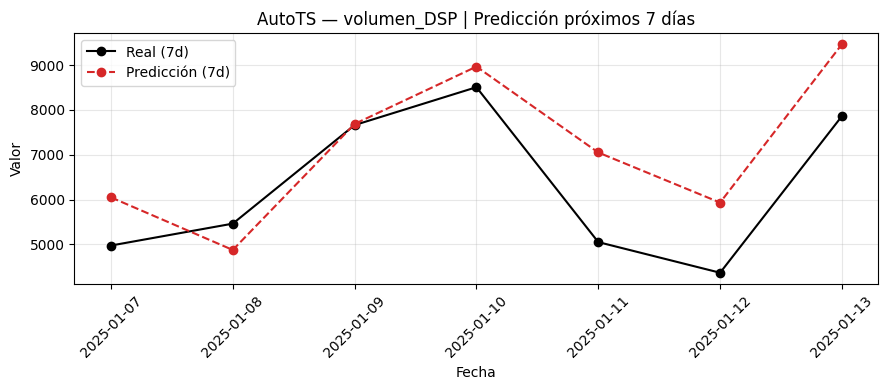

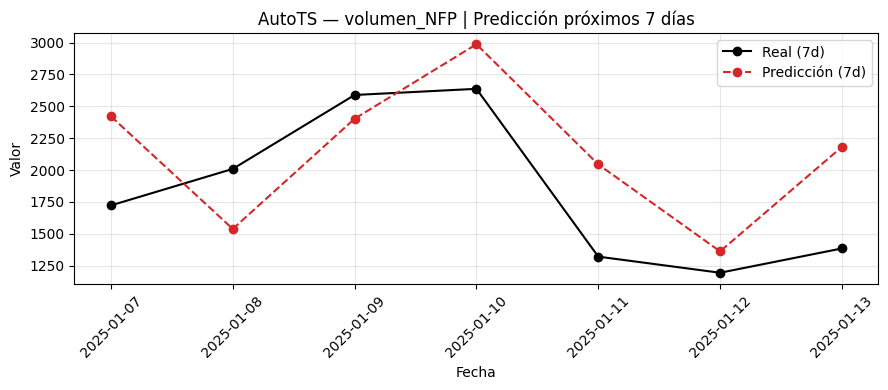

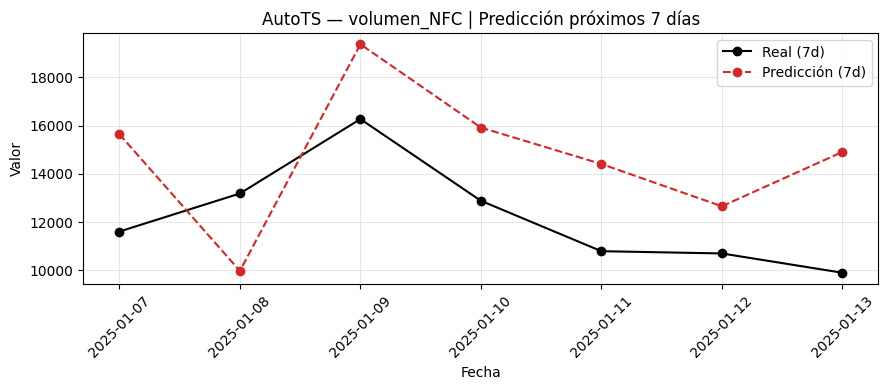

In [ ]:
# Gráficos
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

for col in SERIES:
    plt.figure(figsize=(9,4))
    # Reales
    plt.plot(fc_df.index, test_aligned[col], marker='o', label="Real (7d)", color='black')
    # Predicción
    plt.plot(fc_df.index, fc_df[col], marker='o', linestyle='--', label="Predicción (7d)", color='tab:red')

    plt.title(f"AutoTS — {col} | Predicción próximos 7 días")
    plt.xlabel("Fecha"); plt.ylabel("Valor")
    plt.grid(alpha=0.3); plt.legend()
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d"))
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [ ]:
# Tabla de comparación
out_7d = pd.DataFrame({"ds": fc_df.index})
for col in SERIES:
    out_7d[f"{col}_pred"] = fc_df[col].values
    out_7d[f"{col}_real"] = test_aligned[col].values
display(out_7d)

,ds,volumen_DSP_pred,volumen_DSP_real,volumen_NFP_pred,volumen_NFP_real,volumen_NFC_pred,volumen_NFC_real
0,2025-01-07,6049.555197,4974.666087,2421.160807,1722.929322,15642.360645,11608.359308
1,2025-01-08,4876.206357,5463.411218,1538.438171,2009.270004,9975.158892,13185.305865
2,2025-01-09,7687.969462,7662.526380,2402.697279,2589.072531,19372.799963,16271.081852
3,2025-01-10,8967.795282,8508.161078,2987.005943,2637.363317,15919.546945,12883.809030
4,2025-01-11,7051.028365,5051.258200,2044.367307,1321.018612,14409.377069,10793.387229
5,2025-01-12,5933.071762,4367.571417,1362.108421,1194.650771,12654.663165,10699.740580
6,2025-01-13,9466.381625,7862.785269,2182.033740,1385.200214,14906.876636,9899.660205


In [ ]:
# Ver modelo Seleccionado
def _pretty_json(x):
    try:
        return json.dumps(json.loads(x), indent=2, ensure_ascii=False)
    except Exception:
        # si ya es dict o texto plano
        if isinstance(x, dict):
            return json.dumps(x, indent=2, ensure_ascii=False)
        return str(x)
leaderboard = model.results().copy()

print("Columnas disponibles en leaderboard:")
print(sorted(leaderboard.columns.tolist()))

leaderboard.to_csv("autots_leaderboard.csv", index=False)
print("\nLeaderboard guardado en: autots_leaderboard.csv")
print(f"Total filas (modelos x validaciones): {len(leaderboard)}")

#  TOP-N robusto
TOP_N = 20
preferred_cols = [
    "Model",
    "Ensemble",
    "ModelID",
    "Score",
    "ValidationRound",
    "ModelParameters",
    "TransformationParameters",
    "PerSeries",                 # opcional
    "Notes", "Errors"            # a veces existen
]
cols_exist = [c for c in preferred_cols if c in leaderboard.columns]

topn = leaderboard.sort_values("Score", ascending=True).head(TOP_N)
print(f"\n=== TOP {TOP_N} por Score (menor es mejor) ===")
display(topn[cols_exist])

#Mejor fila y parámetros
best_row = topn.iloc[0]
print("\n=== MEJOR MODELO (según validación interna de AutoTS) ===")
for k in ["Model", "Ensemble", "ModelID", "Score", "ValidationRound"]:
    if k in best_row:
        print(f"{k:>18}: {best_row[k]}")

if "ModelParameters" in best_row and pd.notna(best_row["ModelParameters"]):
    print("\n-- ModelParameters --")
    print(_pretty_json(best_row["ModelParameters"]))

if "TransformationParameters" in best_row and pd.notna(best_row["TransformationParameters"]):
    print("\n-- TransformationParameters --")
    print(_pretty_json(best_row["TransformationParameters"]))

# Info del Ganador
try:
    # Algunas versiones exponen métodos/atributos útiles:
    # model.best_model, model.best_model_name, model.best_model_params, etc.
    print("\n=== Info del ganador desde 'model' (si la versión lo expone) ===")
    for attr in ["best_model", "best_model_name", "best_model_params", "best_model_transformation_params"]:
        if hasattr(model, attr):
            print(f"{attr:>32}: {getattr(model, attr)}")
except Exception as e:
    print(f"(No se pudo leer atributos de mejor modelo desde 'model'): {e}")

if "Model" in leaderboard.columns:
    print("\nTop 10 modelos por frecuencia de aparición:")
    display(leaderboard["Model"].value_counts().head(10).to_frame("count"))

if "FailureRate" in leaderboard.columns:
    approx_failed = float(leaderboard["FailureRate"].fillna(0).sum())
    print(f"\nIntentos fallidos (aprox, sum(FailureRate)): {approx_failed:.1f}")


Columnas disponibles en leaderboard:
['Ensemble', 'Exceptions', 'FitRuntime', 'Generation', 'ID', 'Model', 'ModelParameters', 'PredictRuntime', 'Runs', 'Score', 'TotalRuntime', 'TotalRuntimeSeconds', 'TransformationParameters', 'TransformationRuntime', 'ValidationRound', 'ValidationStartDate', 'containment', 'containment_weighted', 'contour', 'contour_weighted', 'dwae', 'dwae_weighted', 'dwd', 'dwd_weighted', 'ewmae', 'ewmae_weighted', 'imle', 'imle_weighted', 'made', 'made_weighted', 'mae', 'mae_weighted', 'mage', 'mage_weighted', 'mate', 'mate_weighted', 'matse', 'matse_weighted', 'maxe', 'maxe_weighted', 'mle', 'mle_weighted', 'mqae', 'mqae_weighted', 'oda', 'oda_weighted', 'overestimate', 'overestimate_weighted', 'rmse', 'rmse_weighted', 'smape', 'smape_weighted', 'smoothness', 'smoothness_weighted', 'spl', 'spl_weighted', 'underestimate', 'underestimate_weighted', 'uwmse', 'uwmse_weighted', 'wasserstein', 'wasserstein_weighted']

Leaderboard guardado en: autots_leaderboard.csv
Tot

,Model,Ensemble,Score,ValidationRound,ModelParameters,TransformationParameters
767,Ensemble,1,12.246250,0,"{""model_name"": ""BestN"", ""model_count"": 3, ""mod...",{}
773,Ensemble,1,12.555682,0,"{""model_name"": ""BestN"", ""model_count"": 3, ""mod...",{}
774,Ensemble,1,12.588740,0,"{""model_name"": ""BestN"", ""model_count"": 3, ""mod...",{}
771,Ensemble,1,12.588740,0,"{""model_name"": ""BestN"", ""model_count"": 3, ""mod...",{}
772,Ensemble,1,13.081208,0,"{""model_name"": ""BestN"", ""model_count"": 5, ""mod...",{}
768,Ensemble,1,13.263158,0,"{""model_name"": ""BestN"", ""model_count"": 5, ""mod...",{}
770,Ensemble,1,13.731469,0,"{""model_name"": ""BestN"", ""model_count"": 5, ""mod...",{}
627,MetricMotif,0,13.949314,0,"{""window"": 5, ""point_method"": ""weighted_mean"",...","{""fillna"": ""rolling_mean"", ""transformations"": ..."
567,LastValueNaive,0,13.957561,0,{},"{""fillna"": ""rolling_mean"", ""transformations"": ..."
639,LastValueNaive,0,13.957561,0,{},"{""fillna"": ""linear"", ""transformations"": {""0"": ..."



=== MEJOR MODELO (según validación interna de AutoTS) ===
             Model: Ensemble
          Ensemble: 1
             Score: 12.246249743702588
   ValidationRound: 0

-- ModelParameters --
{
  "model_name": "BestN",
  "model_count": 3,
  "model_metric": "best_score",
  "models": {
    "95f62220811f740c706e64424478b72e": {
      "Model": "MetricMotif",
      "ModelParameters": "{\"window\": 5, \"point_method\": \"weighted_mean\", \"distance_metric\": \"mqae\", \"k\": 5, \"comparison_transformation\": {\"fillna\": \"nearest\", \"transformations\": {\"0\": null}, \"transformation_params\": {\"0\": {}}}, \"combination_transformation\": {\"fillna\": \"ffill\", \"transformations\": {\"0\": \"bkfilter\"}, \"transformation_params\": {\"0\": {}}}}",
      "TransformationParameters": "{\"fillna\": \"rolling_mean\", \"transformations\": {\"0\": \"SeasonalDifference\", \"1\": \"AlignLastValue\", \"2\": \"ClipOutliers\", \"3\": \"ClipOutliers\"}, \"transformation_params\": {\"0\": {\"lag_1\": 

,count
Model,
SeasonalNaive,72
VAR,65
LastValueNaive,64
RRVAR,62
SectionalMotif,61
Cassandra,58
FFT,56
SeasonalityMotif,53
DatepartRegression,53


In [ ]:
# Detallers del mejor modelo (ensemble)
best_row = leaderboard.sort_values("Score").iloc[0]

print("=== MEJOR MODELO ===")
print(f"Model: {best_row['Model']}")
print(f"Score: {best_row['Score']:.4f}")

# Si el ensemble tiene detalles internos
if "ModelParameters" in best_row:
    import json
    try:
        params = json.loads(best_row["ModelParameters"])
        print("\n--- Componentes del Ensemble ---")
        for k, v in params.items():
            print(f"{k}: {v}")
    except Exception:
        print("No se pudieron parsear los ModelParameters.")


=== MEJOR MODELO ===
Model: Ensemble
Score: 12.2462

--- Componentes del Ensemble ---
model_name: BestN
model_count: 3
model_metric: best_score
models: {'95f62220811f740c706e64424478b72e': {'Model': 'MetricMotif', 'ModelParameters': '{"window": 5, "point_method": "weighted_mean", "distance_metric": "mqae", "k": 5, "comparison_transformation": {"fillna": "nearest", "transformations": {"0": null}, "transformation_params": {"0": {}}}, "combination_transformation": {"fillna": "ffill", "transformations": {"0": "bkfilter"}, "transformation_params": {"0": {}}}}', 'TransformationParameters': '{"fillna": "rolling_mean", "transformations": {"0": "SeasonalDifference", "1": "AlignLastValue", "2": "ClipOutliers", "3": "ClipOutliers"}, "transformation_params": {"0": {"lag_1": 7, "method": 2}, "1": {"rows": 1, "lag": 28, "method": "additive", "strength": 1.0, "first_value_only": false, "threshold": null}, "2": {"method": "clip", "std_threshold": 1, "fillna": null}, "3": {"method": "clip", "std_thresh